In [326]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from dags import plot_poisson_dag, plot_negative_binomial_dag


# SEED = 19 + 14 ## sum of length of our full names or just use 42
SEED = 19052025

In [327]:
MODEL_PATH_1 = "code_1.stan"
MODEL_PATH_1_PPC = "code_1_pcc.stan"

MODEL_PATH_2 = "code_2.stan"
MODEL_PATH_2_PPC = "code_2_ppc.stan"

### 2. Data Preprocessing

In [328]:
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')
df.head()

/tmp/ipykernel_1005/2798381327.py:1: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [329]:
selected_columns = ['nkill', 'attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']
df = df[selected_columns].dropna()  # Filter out rows where 'nkill' is zero or negative
print(len(df), "rows in the dataset before filtering")
df = df[df['nperps'] > 0]  # Filter out rows where 'nperps' is zero or negative
print(len(df), "rows in the dataset after filtering nperps > 0")
df = df.sample(n=200, random_state=123)
df.to_csv('data.csv')
print(len(df), "rows in the dataset after filtering")
df.head()

106122 rows in the dataset before filtering
27348 rows in the dataset after filtering nperps > 0
200 rows in the dataset after filtering


,nkill,attacktype1,weaptype1,targtype1,country,nperps
9746,35.0,2,5,1,61,100.0
168131,3.0,2,9,3,138,3.0
174923,5.0,2,5,3,4,1.0
125972,7.0,3,6,14,110,1.0
156463,0.0,2,5,22,19,7.0


In [330]:
X = df[['attacktype1', 'weaptype1', 'targtype1', 'nperps', 'country']]

X_norm = (X - X.mean()) / X.std()

N_days = len(df)
print("Number of days/observations:", N_days)


data_sim_ppc = {
    'N': N_days,
    'K': len(X_norm.columns),
    'X': X_norm,
    'nkill': df['nkill'].astype(int),
}


data_sim_prod = {
    'N': N_days,
    'K': len(X_norm.columns),
    'X': X_norm,
    'nkill': df['nkill'].astype(int)
}


X

Number of days/observations: 200


,attacktype1,weaptype1,targtype1,nperps,country
9746,2,5,1,100.0,61
168131,2,9,3,3.0,138
174923,2,5,3,1.0,4
125972,3,6,14,1.0,110
156463,2,5,22,7.0,19
...,...,...,...,...,...
34912,2,5,1,5.0,159
148531,9,13,4,4.0,95
16407,3,6,4,1.0,155
142729,2,5,7,1.0,4


### 3. Model

In [331]:
def scatter_hist_display(val_mat, y_values):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(2, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()

def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    y_real.hist(alpha=0.5, label="Real")
    y_gen.hist(alpha=0.5, label="Generated", bins=23)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.grid()
    plt.show()

def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()

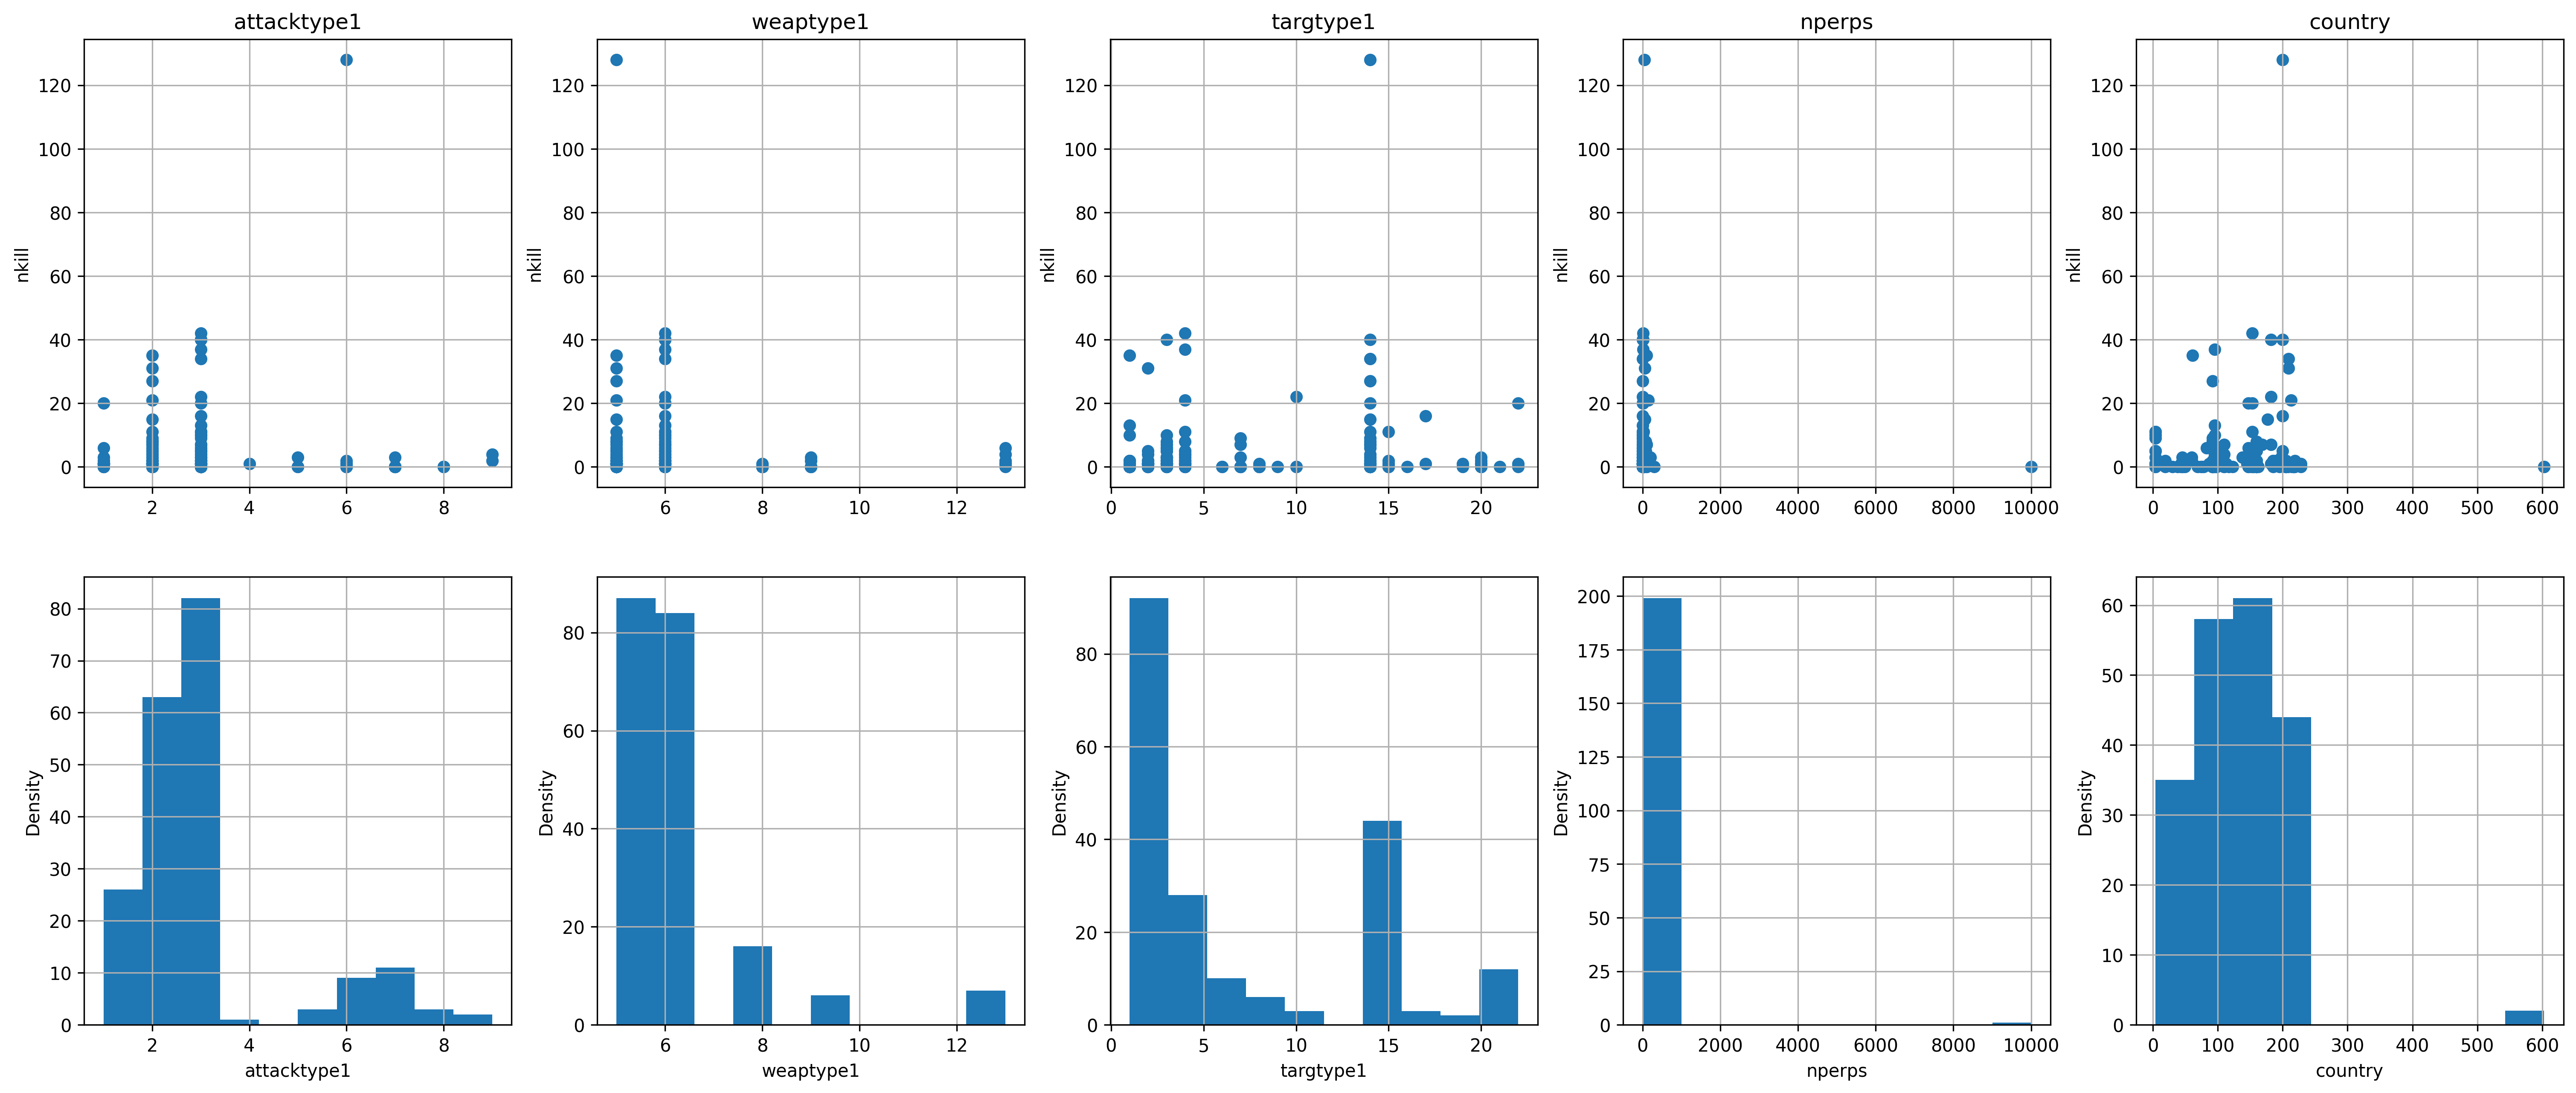

In [332]:
scatter_hist_display(X, df["nkill"])


In [333]:
data_sim_prod

{'N': 200,
 'K': 5,
 'X':         attacktype1  weaptype1  targtype1    nperps   country
 9746      -0.554791  -0.639187  -0.972199  0.052526 -0.890764
 168131    -0.554791   1.772838  -0.649477 -0.084676  0.083232
 174923    -0.554791  -0.639187  -0.649477 -0.087505 -1.611774
 125972     0.029200  -0.036180   1.125492 -0.087505 -0.270948
 156463    -0.554791  -0.639187   2.416379 -0.079018 -1.422034
 ...             ...        ...        ...       ...       ...
 34912     -0.554791  -0.639187  -0.972199 -0.081847  0.348868
 148531     3.533145   4.184863  -0.488117 -0.083262 -0.460688
 16407      0.029200  -0.036180  -0.488117 -0.087505  0.298270
 142729    -0.554791  -0.639187  -0.004034 -0.087505 -1.611774
 166239    -0.554791  -0.639187  -0.649477 -0.086091 -1.422034
 
 [200 rows x 5 columns],
 'nkill': 9746      35
 168131     3
 174923     5
 125972     7
 156463     0
           ..
 34912      0
 148531     4
 16407      1
 142729     0
 166239     2
 Name: nkill, Length: 200, dt

### 4. Priors

#### Model 1

In [334]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)

sim2 = model1_ppc.sample(data=data_sim_ppc,
                        seed=123)

df_1_ppc = sim1.draws_pd()

21:43:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:33 - cmdstanpy - INFO - CmdStan done processing.


In [335]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,4.0,1.0,0.0,0.0,7.0,5.0,1.0,0.0,3.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,17.0,48.0,2.0,112.0,1.0,4.0,4.0,1.0,0.0,26.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,6.0,10.0,14.0,2518.0,14.0,9.0,4.0,17.0,7.0,339.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,40.0,20.0,73.0,5.0,3.0,32.0,36.0,39.0,70.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,70.0,10.0,3.0,0.0,0.0,0.0,0.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,21.0,2.0,0.0,2.0,1.0,0.0,78.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.0,138.0,1.0,3.0,0.0,16.0,12.0,7.0,3.0,12.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,67.0,27.0,42.0,0.0,42.0,0.0,1.0,0.0,318.0


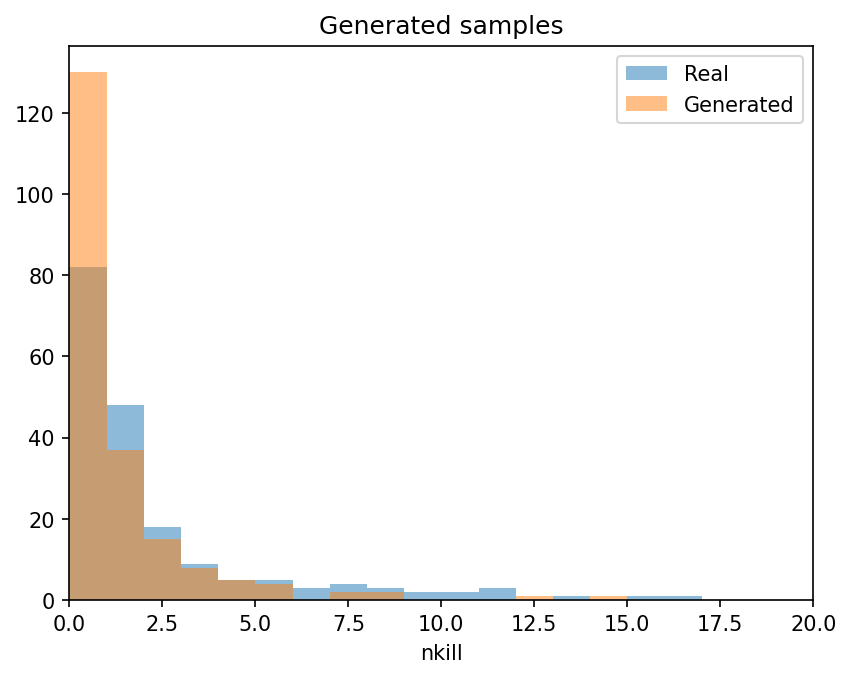

In [336]:
def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()


hist_compare(df['nkill'], df_1_ppc.iloc[0][8:])

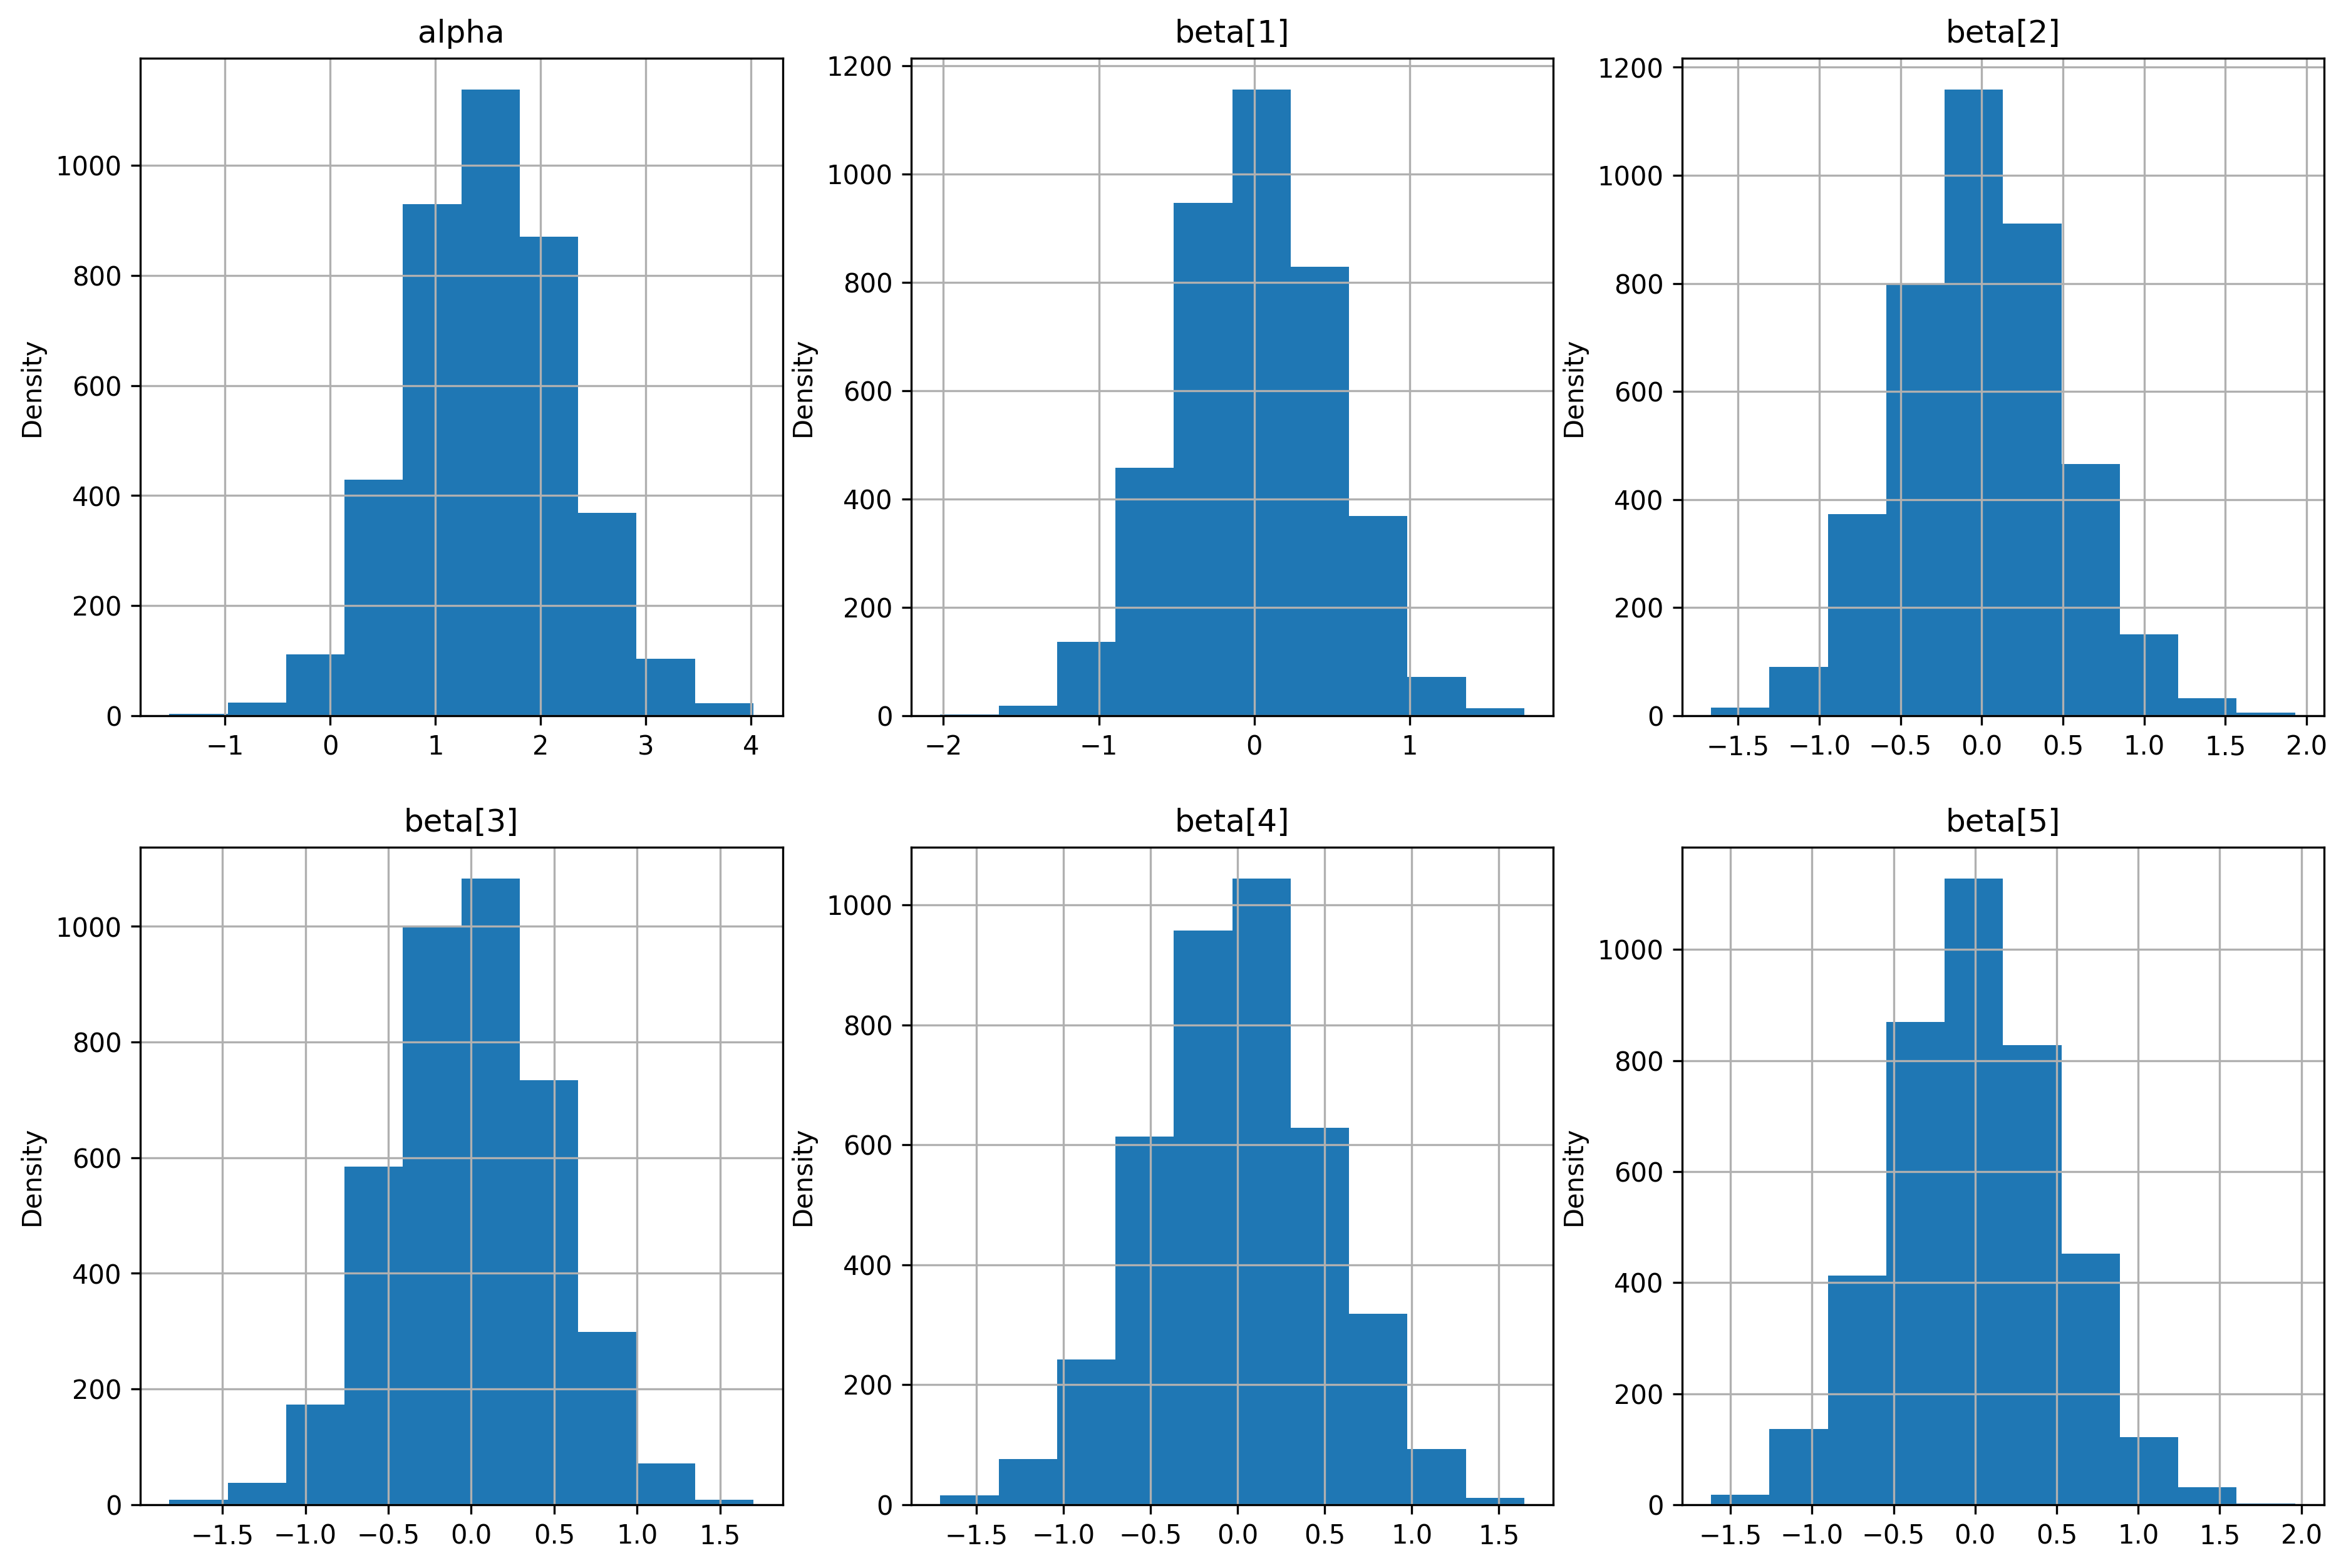

In [337]:
fig, axs = plt.subplots(2, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]']):
    axs[i//3, i%3].hist(df_1_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

In [338]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,4.0,1.0,0.0,0.0,7.0,5.0,1.0,0.0,3.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,17.0,48.0,2.0,112.0,1.0,4.0,4.0,1.0,0.0,26.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,6.0,10.0,14.0,2518.0,14.0,9.0,4.0,17.0,7.0,339.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,40.0,20.0,73.0,5.0,3.0,32.0,36.0,39.0,70.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,70.0,10.0,3.0,0.0,0.0,0.0,0.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,21.0,2.0,0.0,2.0,1.0,0.0,78.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.0,138.0,1.0,3.0,0.0,16.0,12.0,7.0,3.0,12.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,67.0,27.0,42.0,0.0,42.0,0.0,1.0,0.0,318.0


Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200


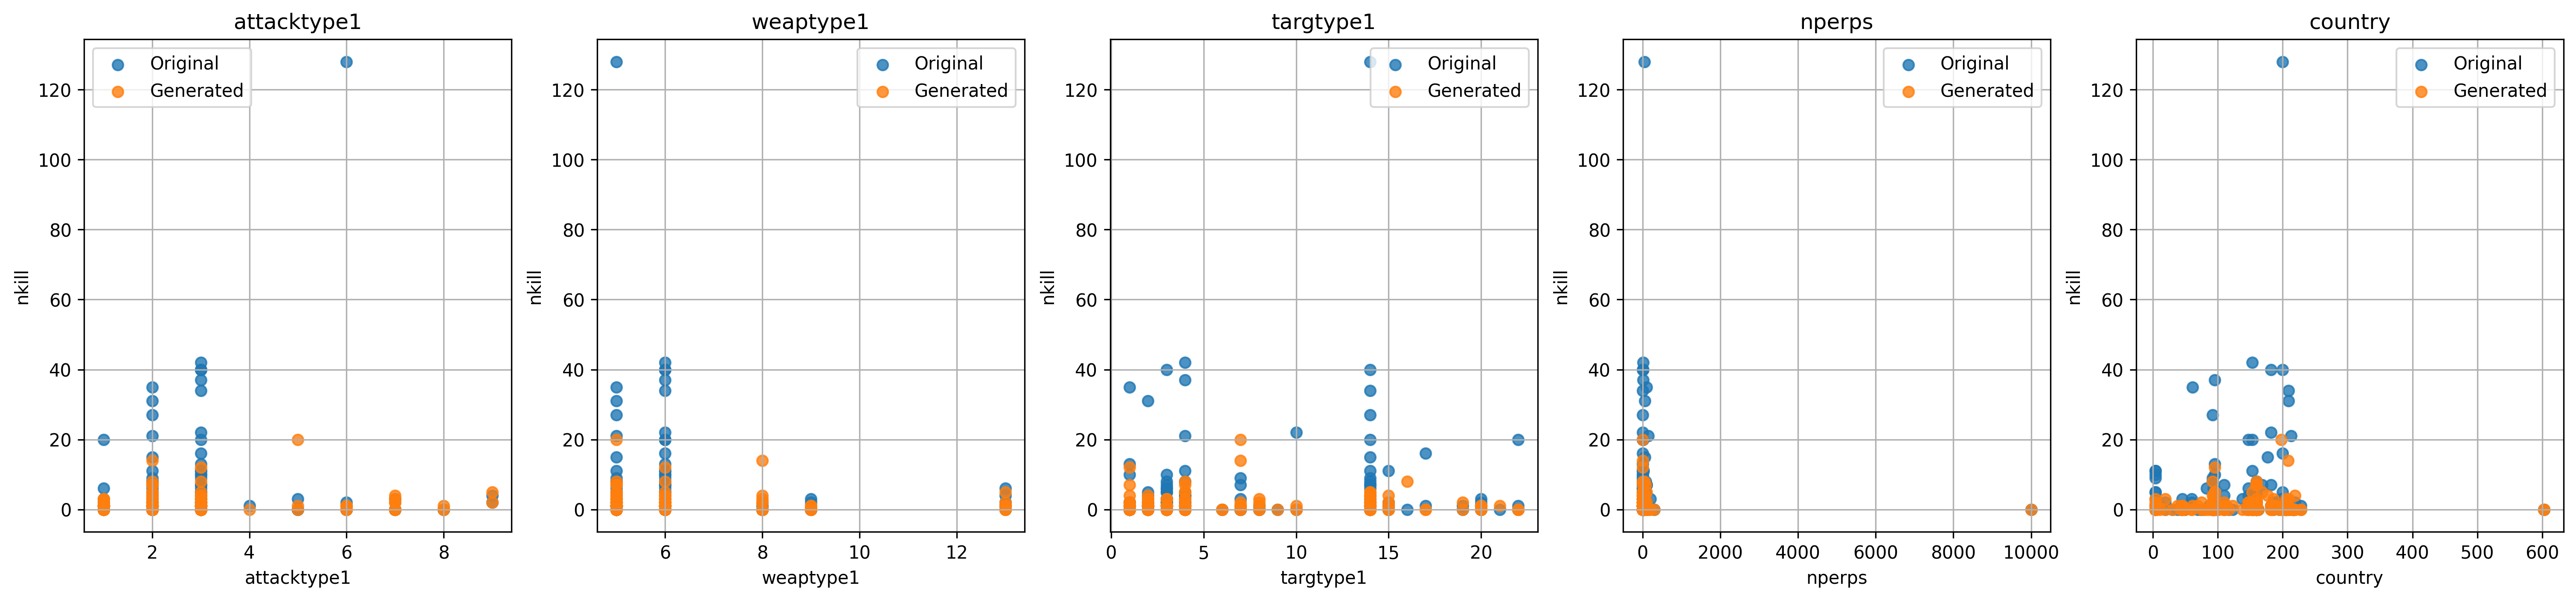

In [341]:
def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    # plt.figure(dpi=300)
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        
        print(f"Rozmiar x (val_mat[col]): {len(val_mat[col])}")
        print(f"Rozmiar y (y_values_gen): {len(y_values_gen)}")
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()


scatter_compare_display(X, df["nkill"], df_1_ppc.iloc[0][17:])

In [ ]:
df_1_ppc

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,nkill_sim[191],nkill_sim[192],nkill_sim[193],nkill_sim[194],nkill_sim[195],nkill_sim[196],nkill_sim[197],nkill_sim[198],nkill_sim[199],nkill_sim[200]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,4.0,1.0,0.0,0.0,7.0,5.0,1.0,0.0,3.0
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,17.0,48.0,2.0,112.0,1.0,4.0,4.0,1.0,0.0,26.0
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,6.0,10.0,14.0,2518.0,14.0,9.0,4.0,17.0,7.0,339.0
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,40.0,20.0,73.0,5.0,3.0,32.0,36.0,39.0,70.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,70.0,10.0,3.0,0.0,0.0,0.0,0.0
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,21.0,2.0,0.0,2.0,1.0,0.0,78.0
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.0,138.0,1.0,3.0,0.0,16.0,12.0,7.0,3.0,12.0
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,0.0,67.0,27.0,42.0,0.0,42.0,0.0,1.0,0.0,318.0


#### Model 2

In [342]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PPC)

sim1 = model1_ppc.sample(data=data_sim_ppc,
                        seed=123)

df_2_ppc = sim1.draws_pd()

21:43:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:59 - cmdstanpy - INFO - CmdStan done processing.
21:43:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 1.50682e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 21, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.0104e+09, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 21, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 5.68275e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 21, column 4 to column 85)
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.0125e+10, but must be less than 1073741824.000000 (in 'code_2_ppc.stan', line 21, column 4 to column 85)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.58556e+13, but

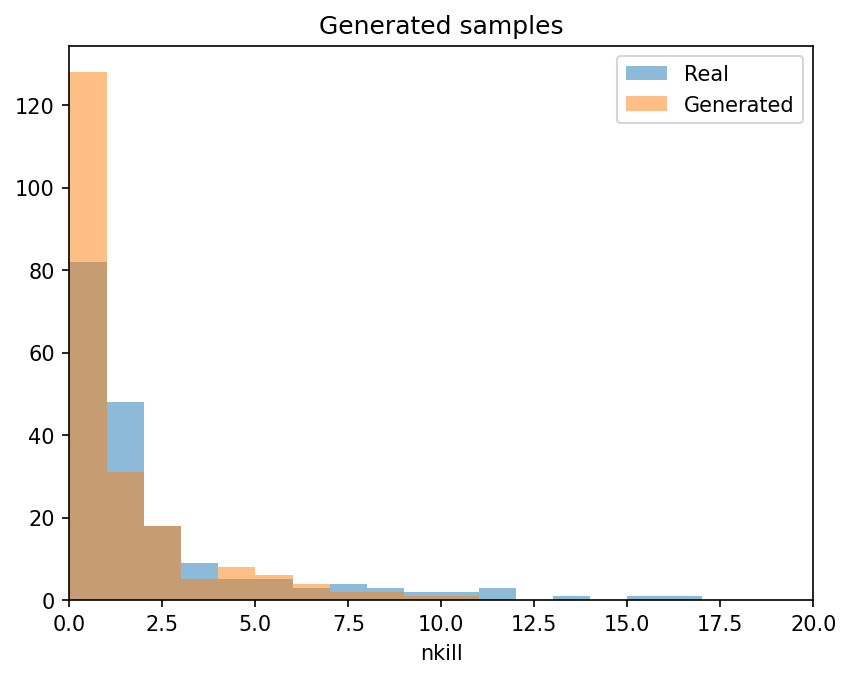

In [343]:
def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()


hist_compare(df['nkill'], df_2_ppc.iloc[0][8:])

In [344]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_2_ppc.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 82, Predicted = 128
Number of victims = 1: Real = 48, Predicted = 32
Number of victims = 2: Real = 18, Predicted = 17
Number of victims = 3: Real = 9, Predicted = 6
Number of victims = 4: Real = 5, Predicted = 8
Number of victims = 5: Real = 5, Predicted = 6
Number of victims = 6: Real = 3, Predicted = 4
Number of victims = 7: Real = 4, Predicted = 2
Number of victims = 8: Real = 3, Predicted = 2
Number of victims = 9: Real = 2, Predicted = 1
Number of victims = 10: Real = 2, Predicted = 1
Number of victims = 11: Real = 3, Predicted = 0
Number of victims = 13: Real = 1, Predicted = 0
Number of victims = 15: Real = 1, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 0
Number of victims = 20: Real = 2, Predicted = 0
Number of victims = 21: Real = 1, Predicted = 0
Number of victims = 22: Real = 1, Predicted = 0
Number of victims = 27: Real = 1, Predicted = 0
Number of victims = 31: Real = 1, Predicted = 0
Number of victims = 34: Real = 1, Predicted

Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200


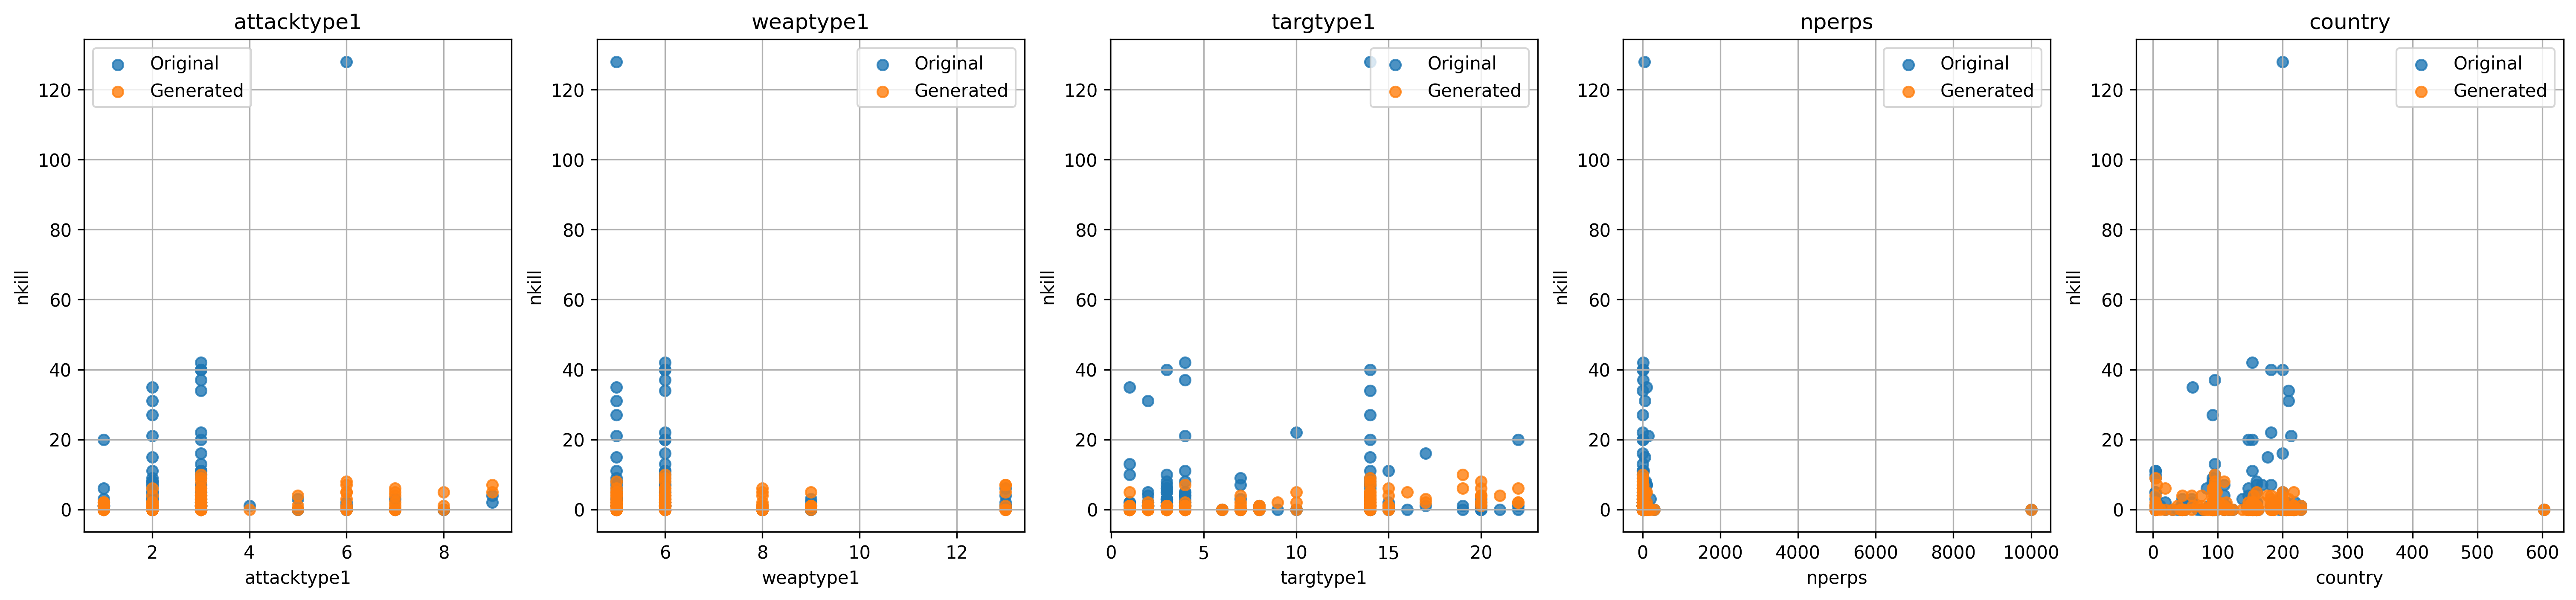

In [345]:
scatter_compare_display(X, df["nkill"], df_2_ppc.iloc[0][17:])

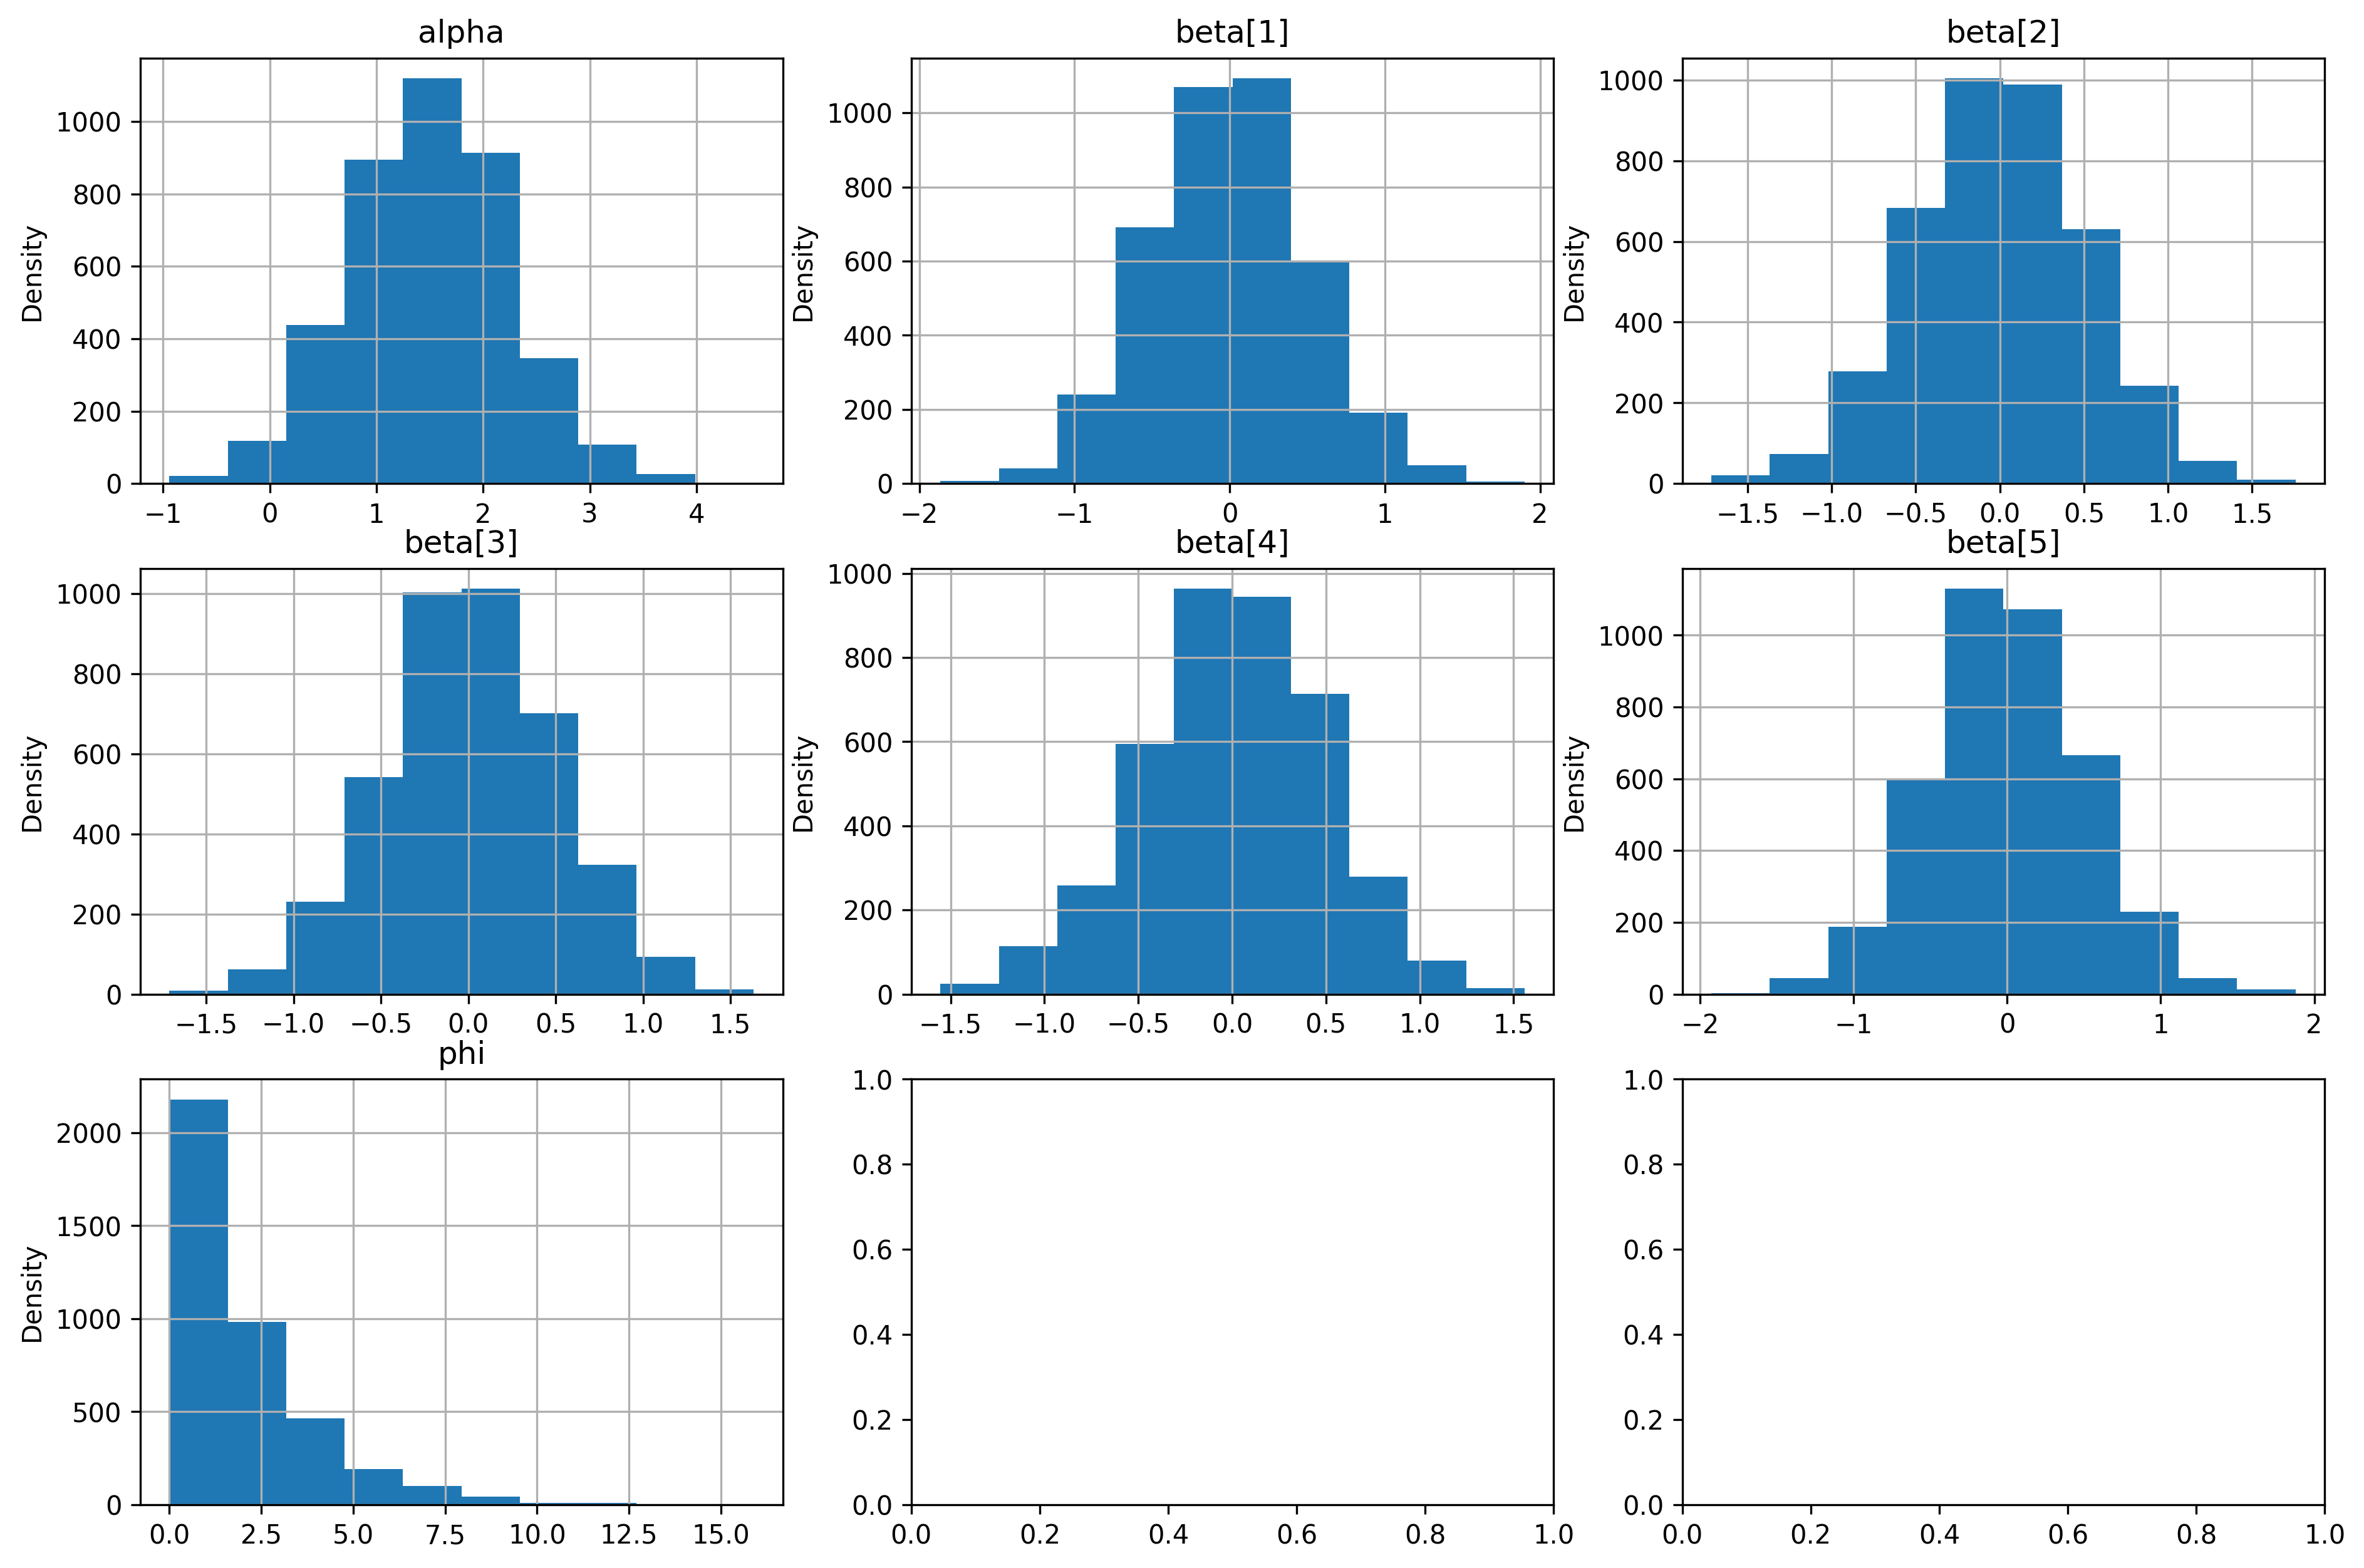

In [346]:
fig, axs = plt.subplots(3, 3, dpi=300)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'phi']):
    axs[i//3, i%3].hist(df_2_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

### 5. Posterior analysis

#### Model 1

In [347]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_1)

sim1_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_1_prod = sim1_prod.draws_pd()

21:44:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:09 - cmdstanpy - INFO - CmdStan done processing.


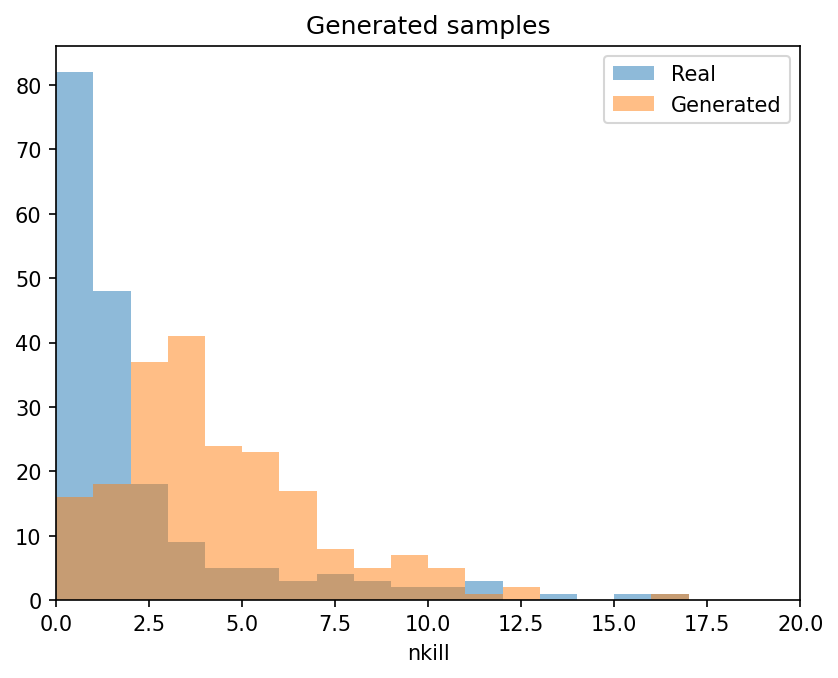

In [348]:
hist_compare(df['nkill'], df_1_prod.iloc[0][8:])

In [349]:
for n in range(0, 100):
    true_count = np.sum(df['nkill'] == n)
    pred_count = np.sum(np.round(df_1_prod.iloc[0][8:]) == n)
    if true_count != 0 or pred_count != 0:
        print(f"Number of victims = {n}: Real = {true_count}, Predicted = {pred_count}")

Number of victims = 0: Real = 82, Predicted = 18
Number of victims = 1: Real = 48, Predicted = 18
Number of victims = 2: Real = 18, Predicted = 37
Number of victims = 3: Real = 9, Predicted = 41
Number of victims = 4: Real = 5, Predicted = 24
Number of victims = 5: Real = 5, Predicted = 23
Number of victims = 6: Real = 3, Predicted = 17
Number of victims = 7: Real = 4, Predicted = 8
Number of victims = 8: Real = 3, Predicted = 5
Number of victims = 9: Real = 2, Predicted = 7
Number of victims = 10: Real = 2, Predicted = 5
Number of victims = 11: Real = 3, Predicted = 1
Number of victims = 12: Real = 0, Predicted = 2
Number of victims = 13: Real = 1, Predicted = 0
Number of victims = 15: Real = 1, Predicted = 0
Number of victims = 16: Real = 1, Predicted = 1
Number of victims = 20: Real = 2, Predicted = 0
Number of victims = 21: Real = 1, Predicted = 0
Number of victims = 22: Real = 1, Predicted = 0
Number of victims = 27: Real = 1, Predicted = 0
Number of victims = 31: Real = 1, Predic

Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200


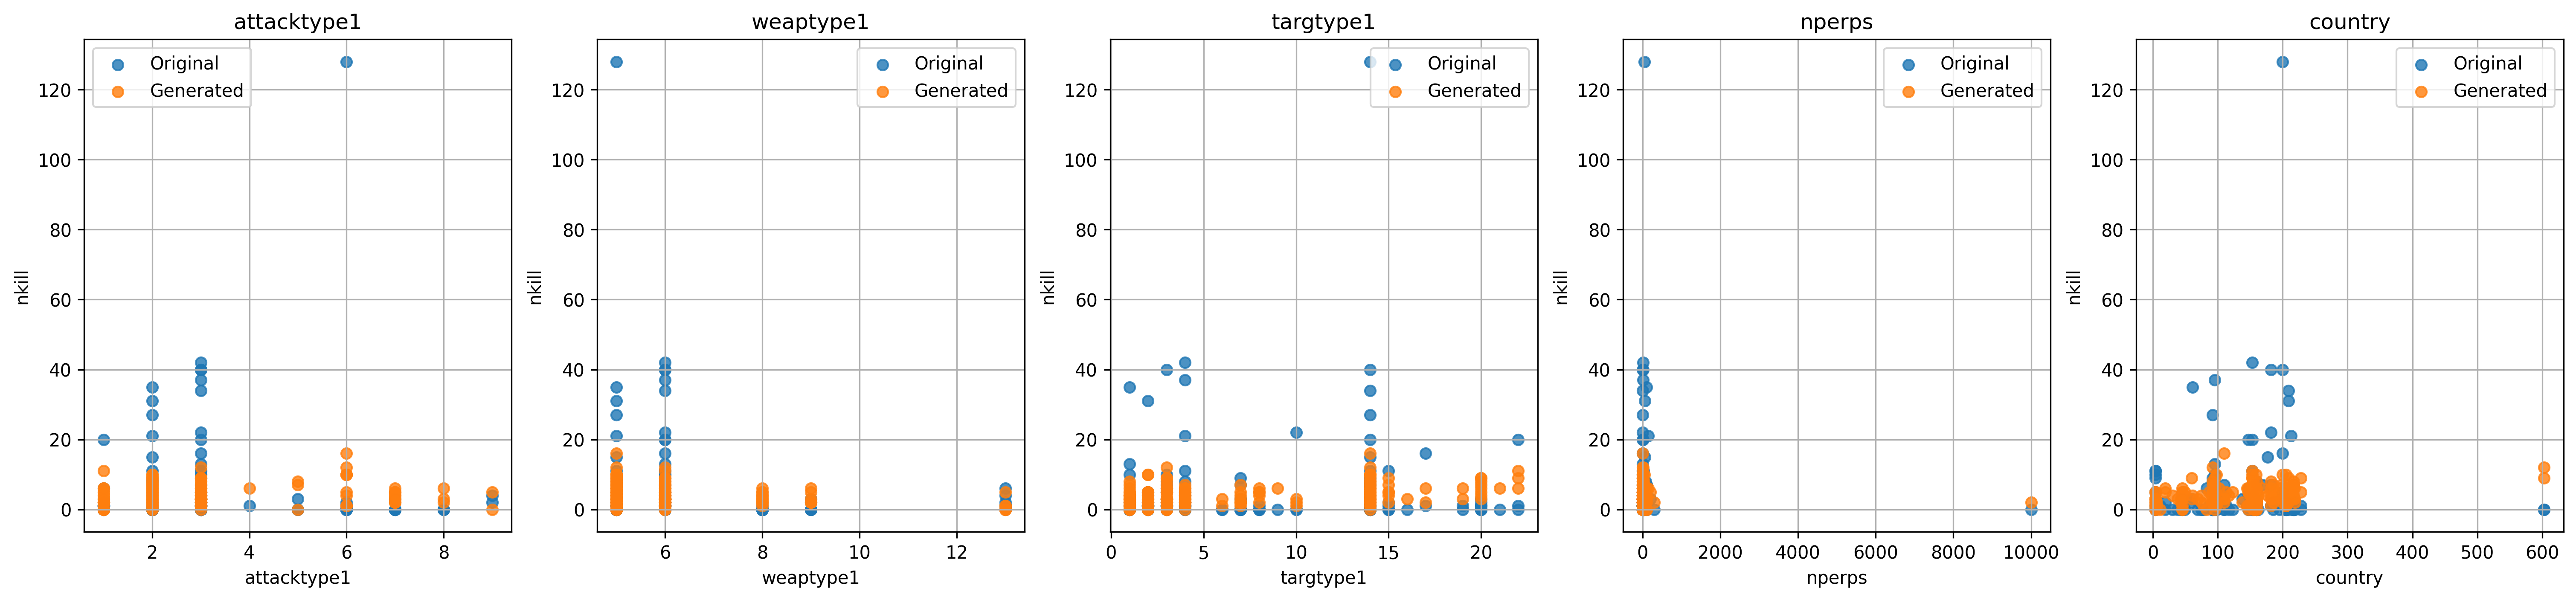

In [350]:
scatter_compare_display(X, df["nkill"], df_1_prod.iloc[0][16:])

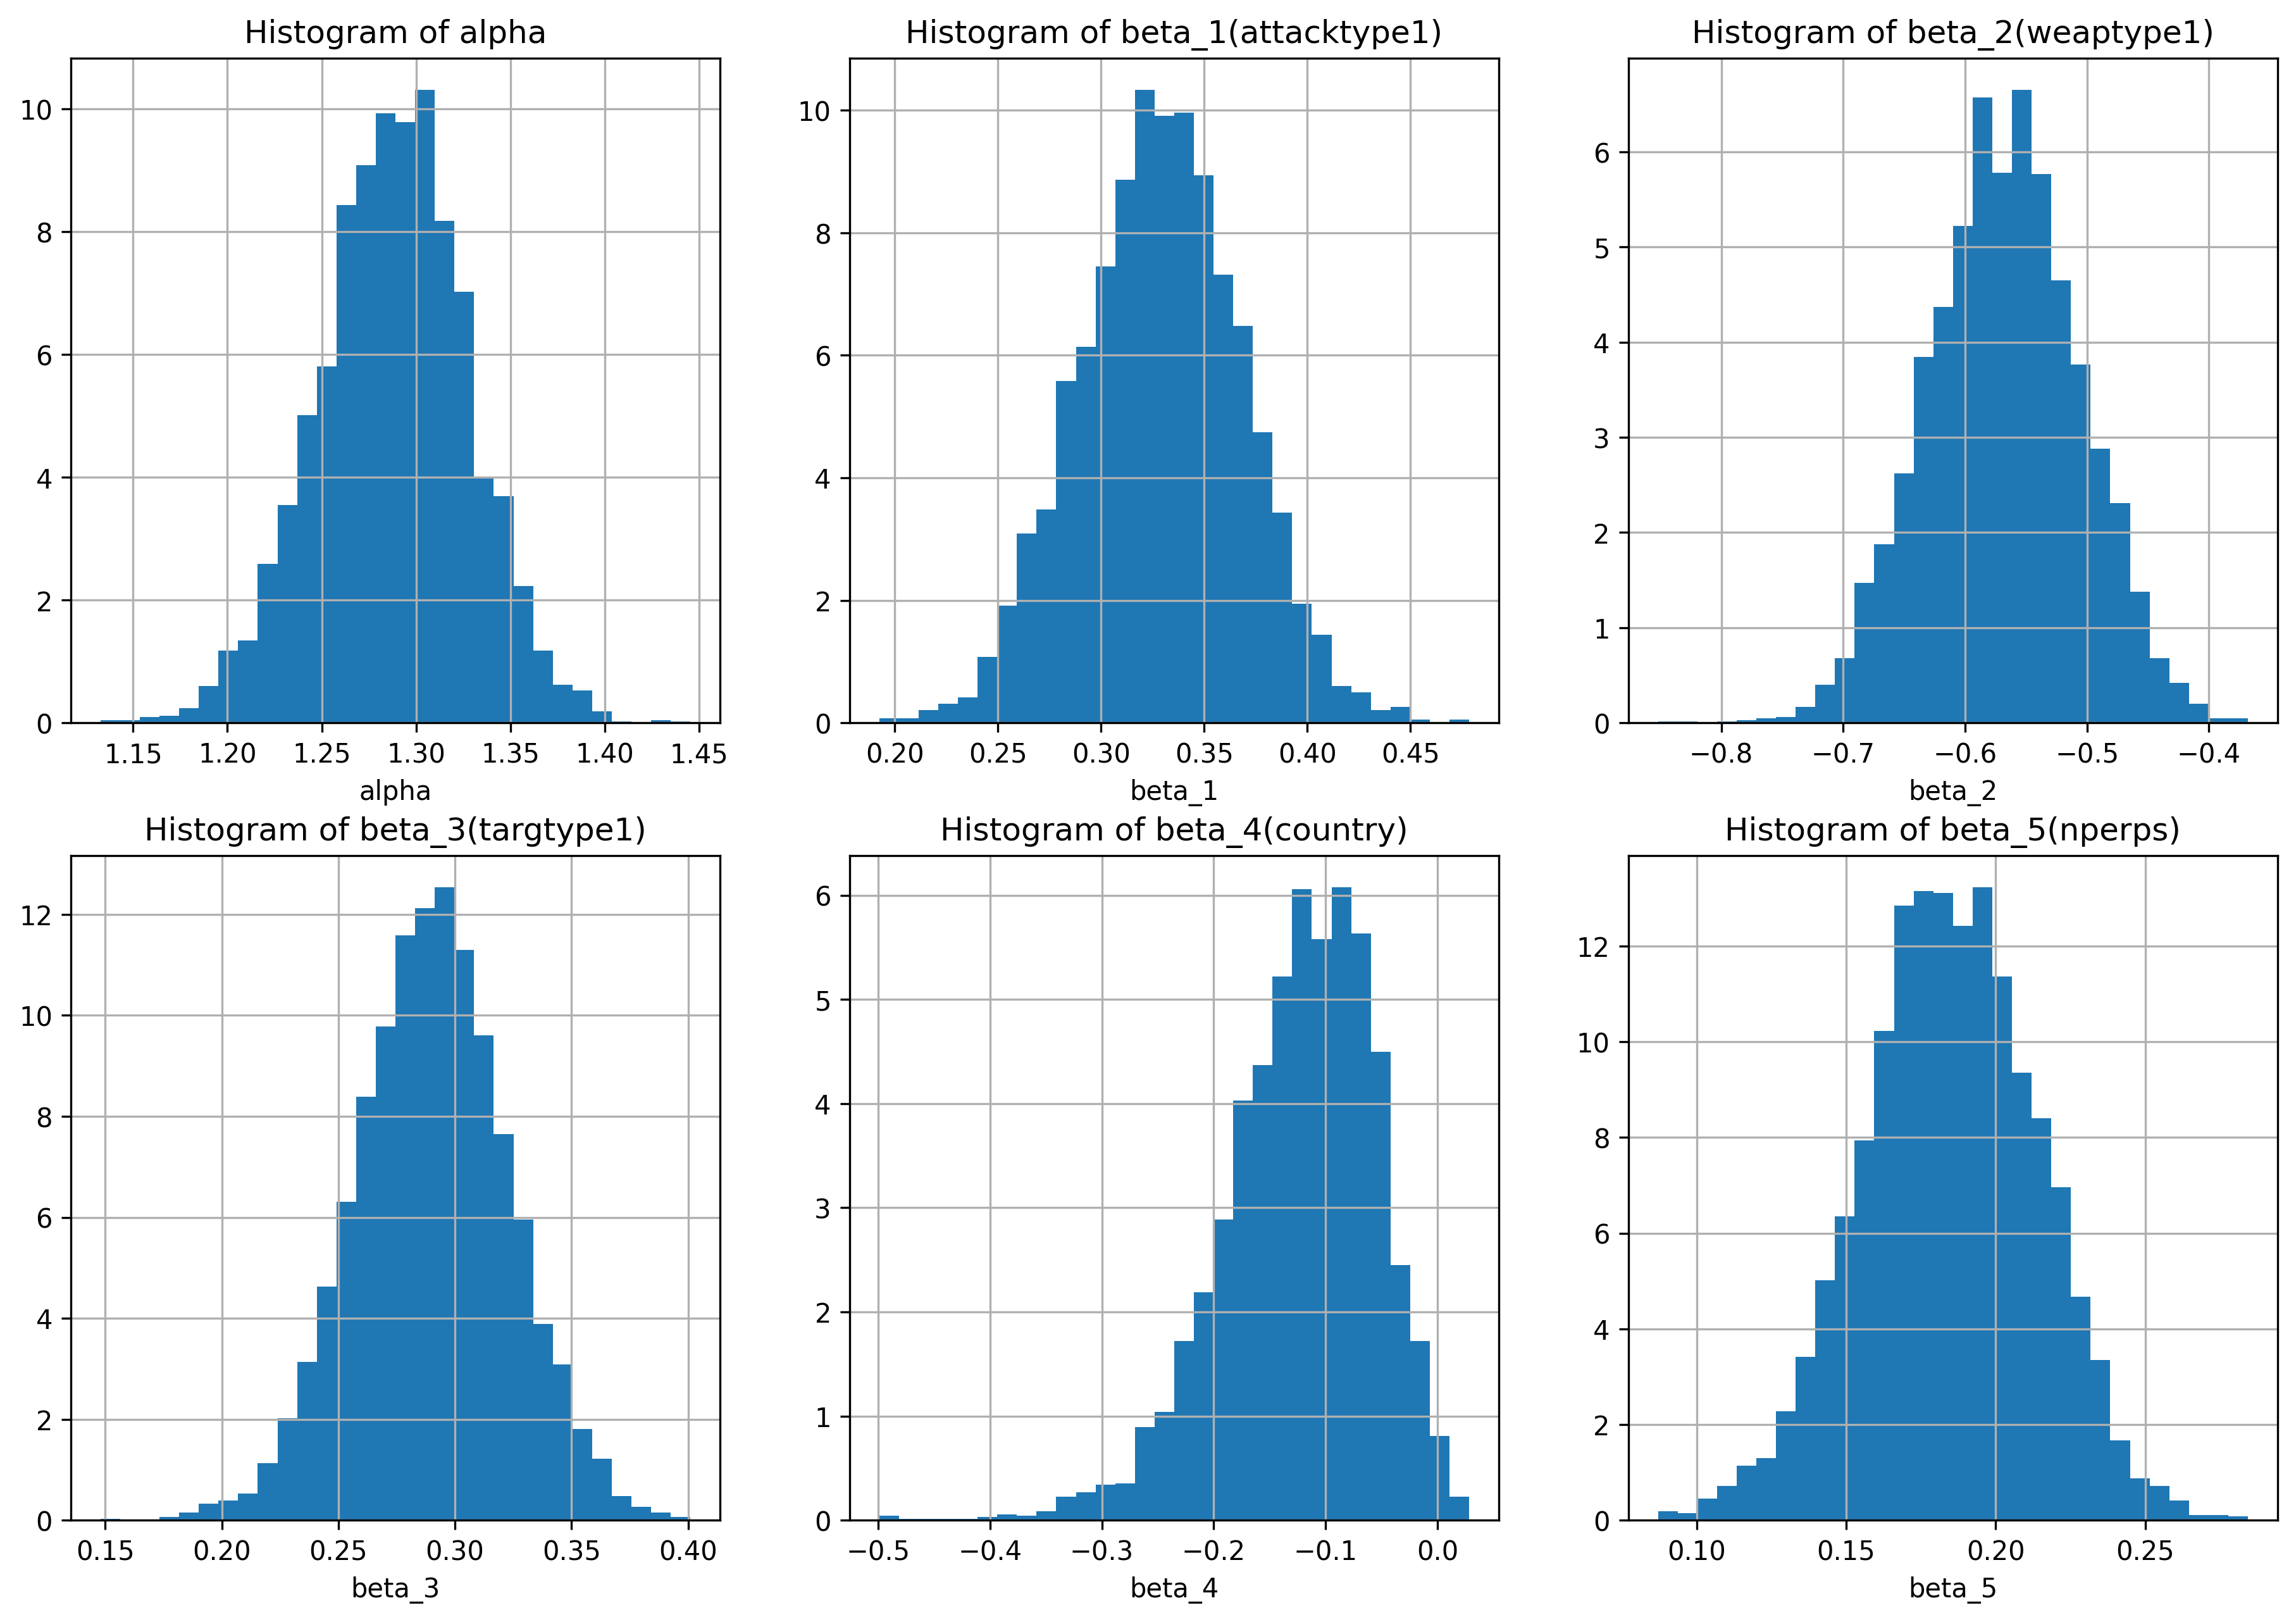

In [351]:
alpha = sim1_prod.stan_variable('alpha')
beta = sim1_prod.stan_variable('beta')

# plt.figure(dpi=300)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()


plt.show()

#### Model 2


In [352]:
model1_prod = CmdStanModel(stan_file=MODEL_PATH_2)

sim2_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_2_prod = sim2_prod.draws_pd()

21:44:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:21 - cmdstanpy - INFO - CmdStan done processing.
21:44:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code_2.stan', line 19, column 2 to column 52)
Consider re-running with show_console=True if the above output is unclear!


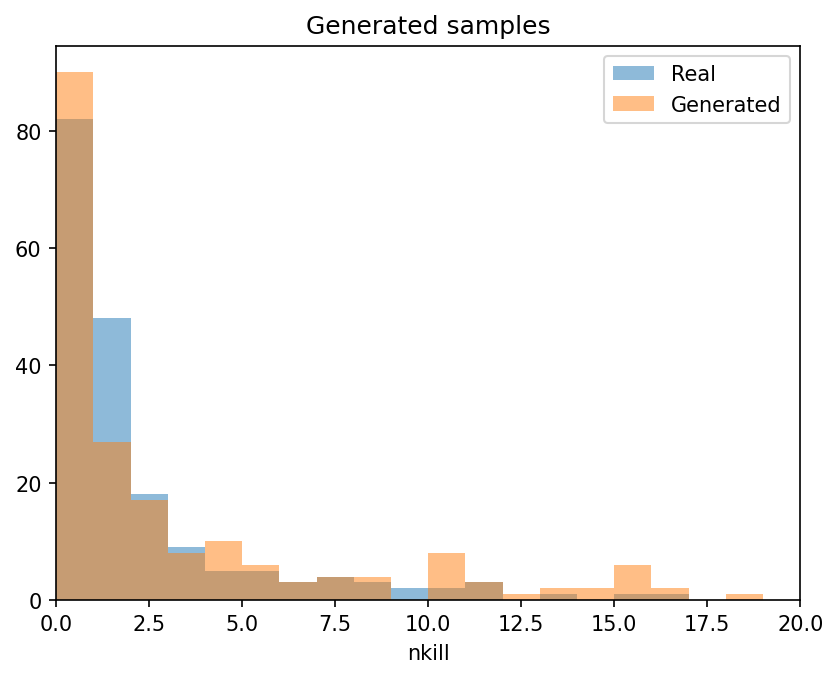

In [353]:
hist_compare(df['nkill'], df_2_prod.iloc[0][8:])

Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200
Rozmiar x (val_mat[col]): 200
Rozmiar y (y_values_gen): 200


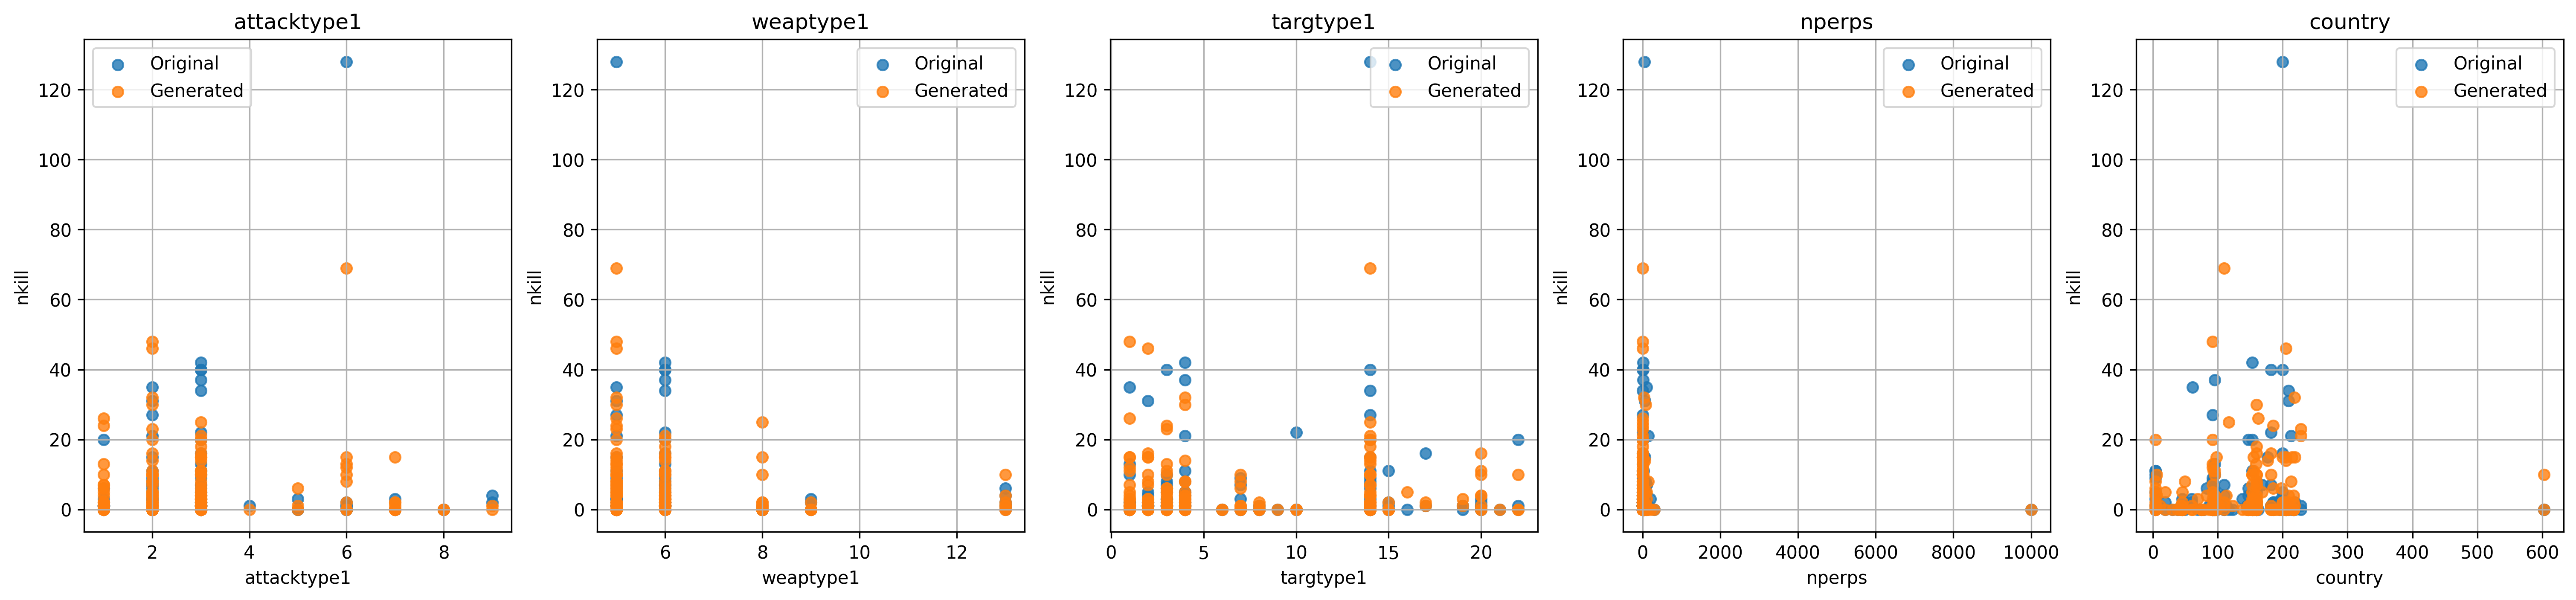

In [354]:
scatter_compare_display(X, df["nkill"], df_2_prod.iloc[0][17:])

alpha shape: (4000,)
beta shape: (4000, 5)
[[ 0.0985926  -0.278027    0.0184197  -0.224862    0.0431184 ]
 [ 0.188811   -0.0324176   0.446953   -0.497603    0.307154  ]
 [ 0.00564068 -0.331904    0.0229874   0.308413   -0.0838599 ]
 ...
 [ 0.134612   -0.296009    0.214218   -0.471042    0.364583  ]
 [-0.0318048  -0.227652    0.202501   -0.141224    0.247042  ]
 [ 0.226267   -0.130306    0.334241   -0.184833    0.200542  ]]


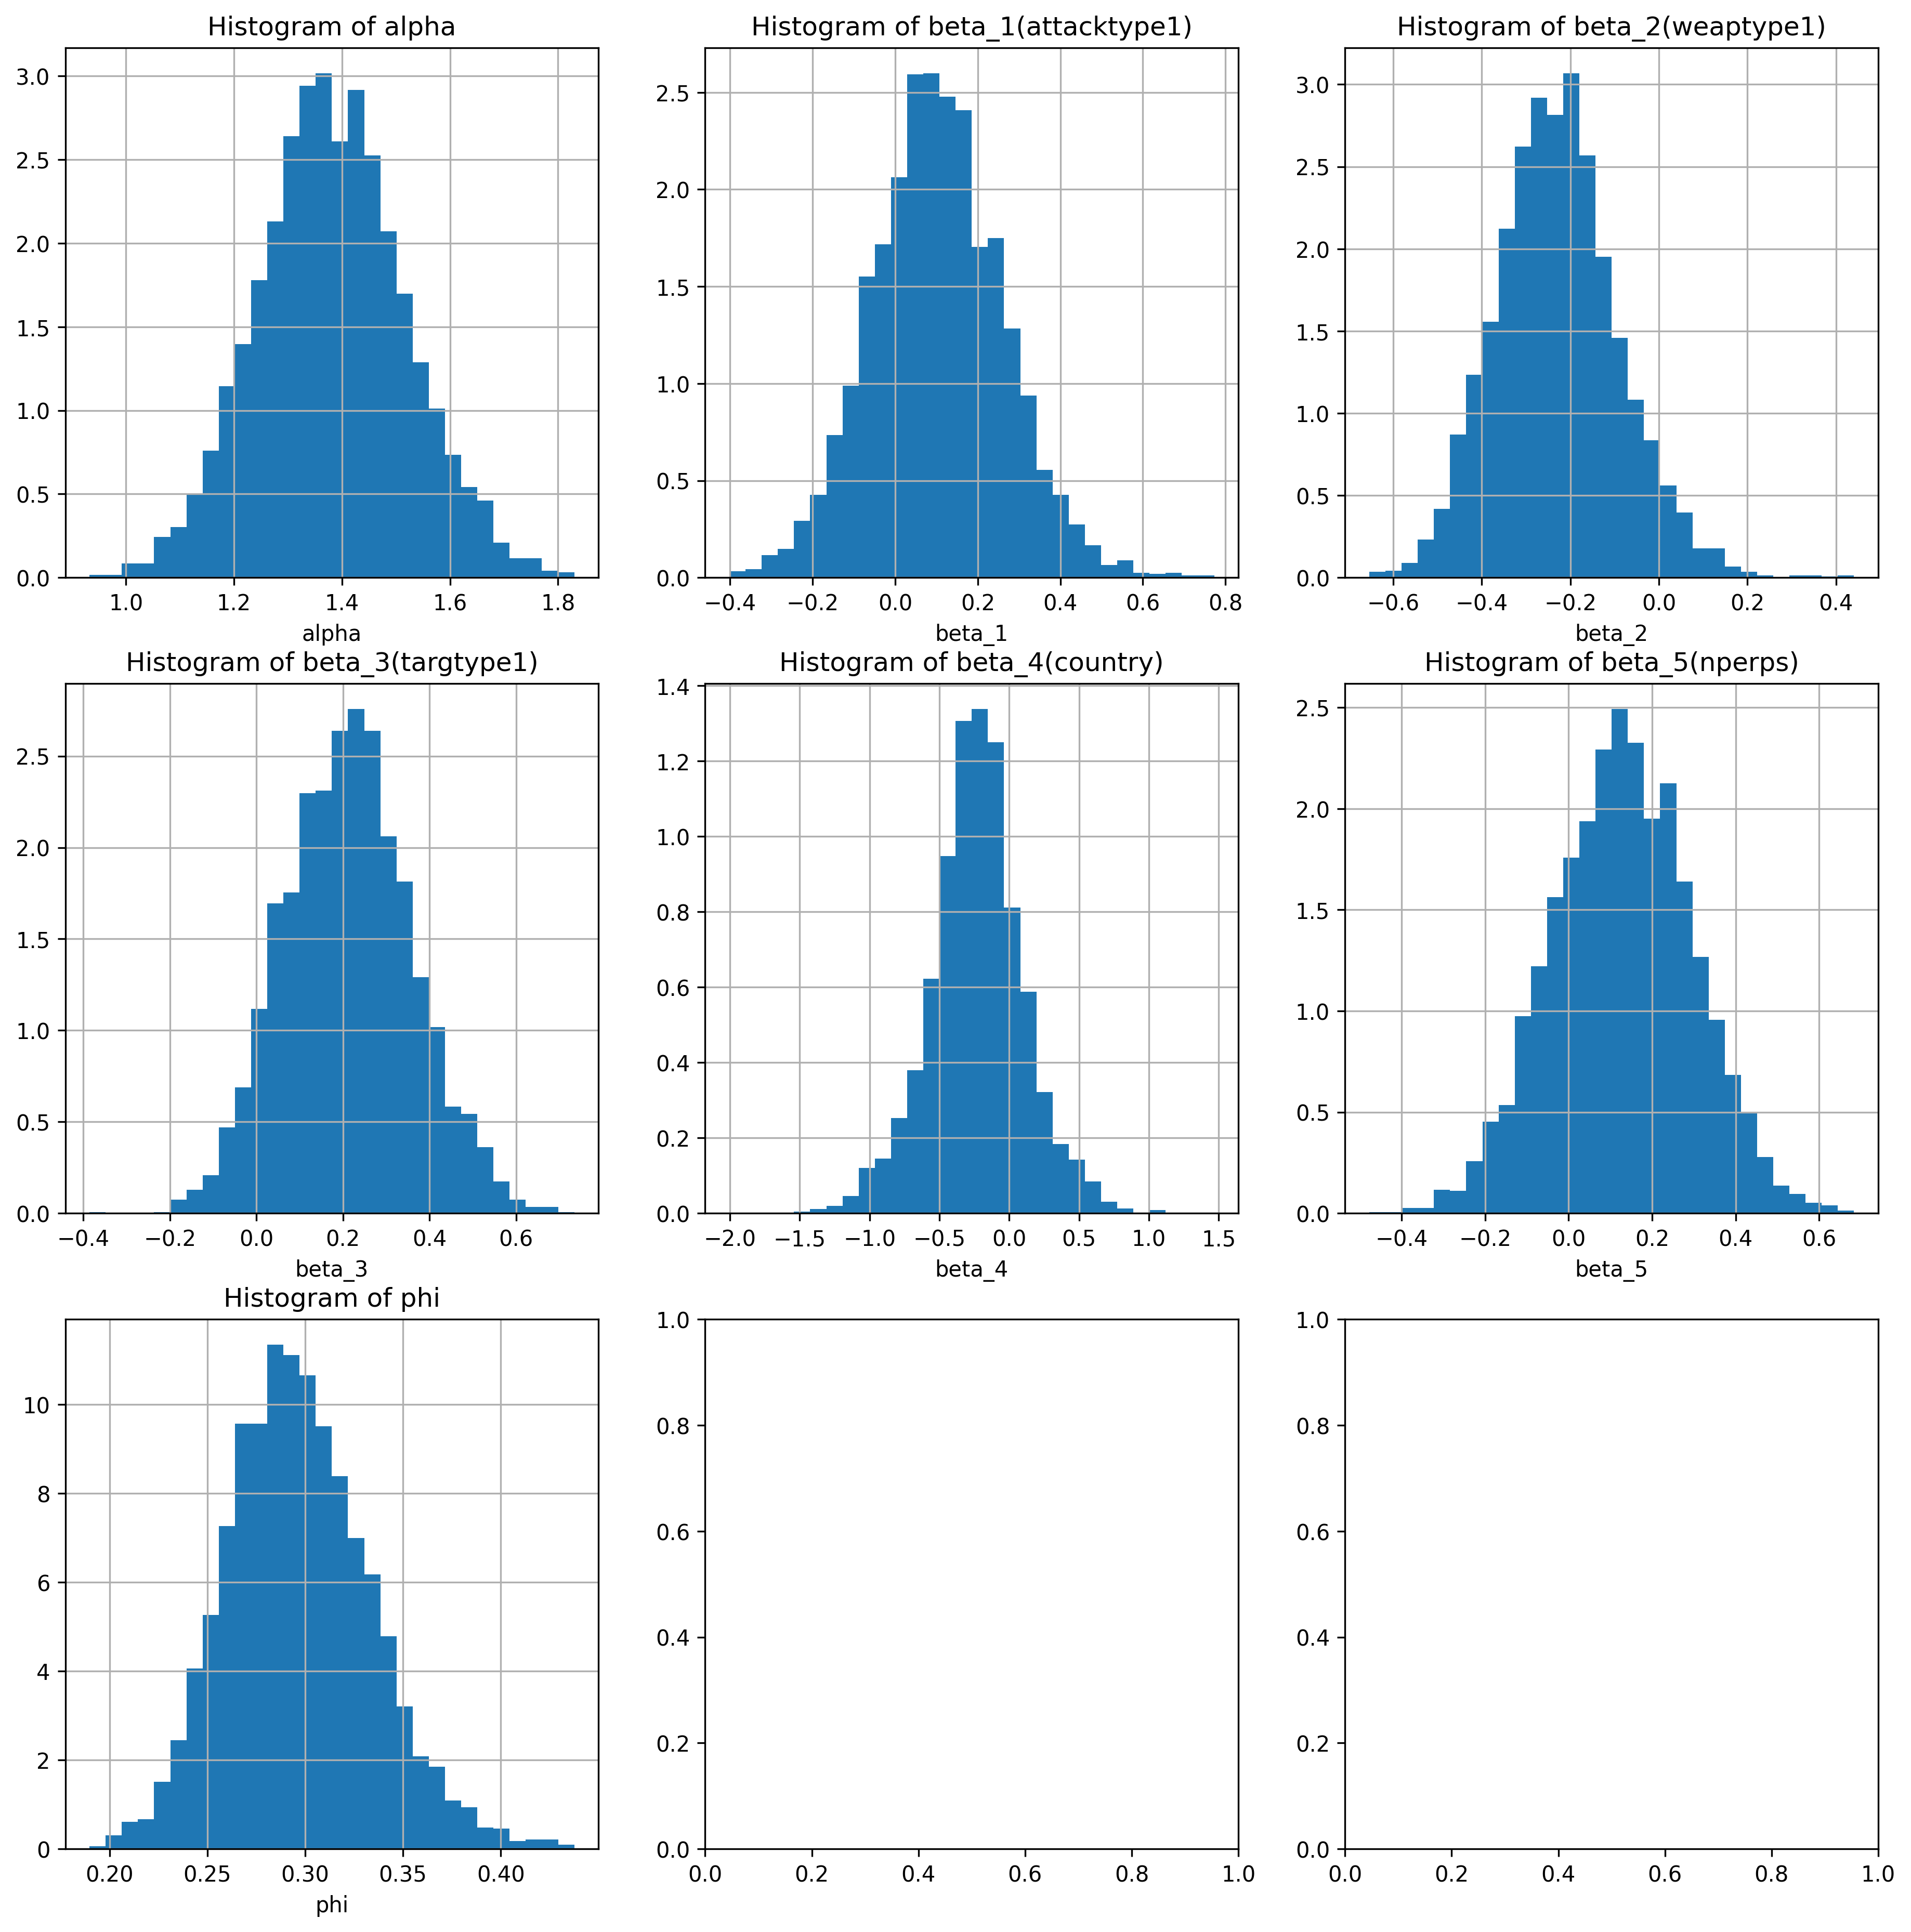

In [355]:
alpha = sim2_prod.stan_variable('alpha')
beta = sim2_prod.stan_variable('beta')
phi = sim2_prod.stan_variable('phi')
print("alpha shape:", alpha.shape)
print("beta shape:", beta.shape)
print(beta)

# plt.figure(dpi=300)
fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(['attacktype1', 'weaptype1', 'targtype1', 'country', 'nperps']):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()

axes[2, 0].hist(phi, bins=30, density=True)
axes[2, 0].set_title(f'Histogram of phi')
axes[2, 0].set_xlabel(f'phi')
axes[2, 0].grid()


plt.show()

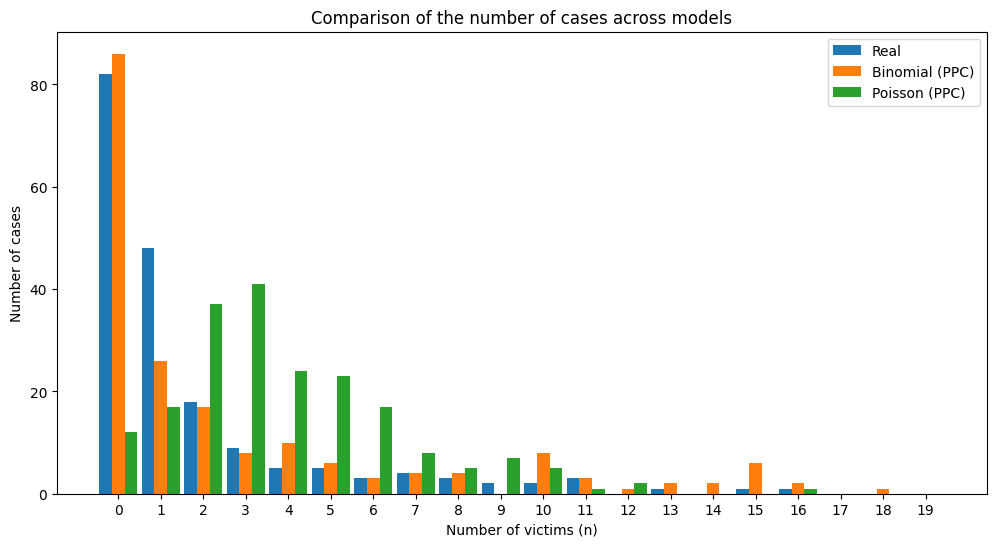

In [356]:
n_values = np.arange(0, 20)


true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(df["nkill"].values == n)
    binomial_count = np.sum(np.round(df_2_prod.iloc[0][16:]) == n)
    poisson_count = np.sum(np.round(df_1_prod.iloc[0][16:]) == n)
    
    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()

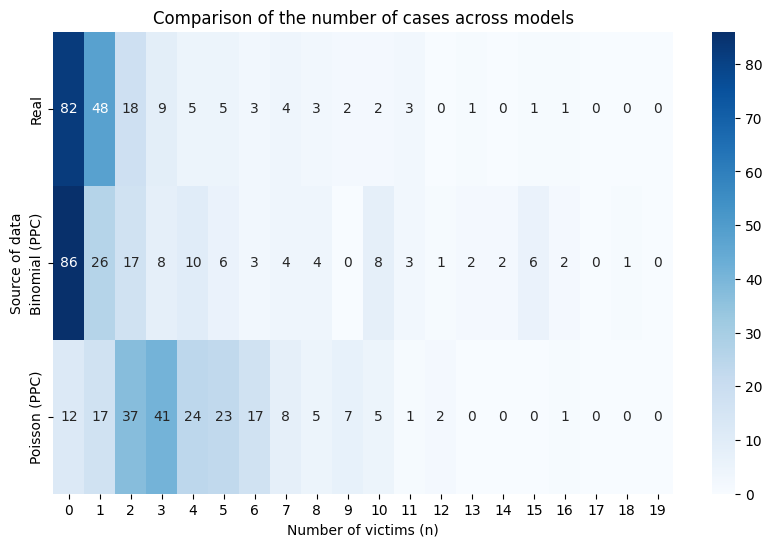

In [357]:
df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()